# Movie Classification Project

## Introduction

This project focuses on building a classification model to predict whether a movie belongs to the Comedy or Thriller genre based solely on the frequency of selected words in its screenplay. By the end of this project, we aim to:

1. Build a k-nearest-neighbors (k-NN) classifier.
2. Evaluate the performance of the classifier.

The dataset contains word frequencies derived from movie screenplays, transformed into a "bag-of-words" representation. This representation is a common technique in natural language processing (NLP) and serves as a foundation for machine learning applications.

## Table of Contents

1. [Exploratory Data Analysis](#exploratory-data-analysis)
2. [Data Splitting](#data-splitting)
3. [Building and Evaluating the Classifier](#building-and-evaluating-the-classifier)
4. [Conclusion](#conclusion)


In [1]:
# Importing libraries
import numpy as np
import math
import datascience
from datascience import *

# These lines set up the plotting functionality and formatting
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter("ignore")

---

## Dataset Overview

The dataset comprises 5,000 word frequency columns for each movie, alongside metadata such as title, genre, and release year. The data is preprocessed to convert words to lowercase and remove offensive terms. Below is an example of a single row for the movie "Runaway Bride":

In [ ]:
movies = Table.read_table('movies.csv')

Here is one row of the table and some of the frequencies of words that were said in the movie.

In [ ]:
movies.where("Title", "runaway bride").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
runaway bride,1999,5.2,comedy,4895,0,0,0.0234092,0


The above cell prints a few columns of the row for the comedy movie *Runaway Bride*.  The movie contains 4895 words. The word "it" appears 115 times, as it makes up  $\frac{115}{4895} \approx 0.0234092$ of the words in the movie. The word "england" doesn't appear at all.

In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title.

*Note: All movies in our dataset have their titles lower-cased.*

In [ ]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)

    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

row_for_title('toy story')

Row(Title='toy story', Year='1995', Rating=8.2, Genre='comedy', # Words=3016, she=0.0017427675148135, decid=0.0003485535029627, talk=0.0017427675148135, wit=0.0, razor=0.0, slam=0.0, credit=0.0, rai=0.0, hugh=0.0, breez=0.0, conscienc=0.0, audienc=0.0, cathi=0.0, log=0.0, met=0.0, chosen=0.0, grip=0.0, booz=0.0, bianca=0.0, doubl=0.0003485535029627, agent=0.0, exit=0.0, carpent=0.0, underground=0.0, clemenza=0.0, gain=0.0, neg=0.0006971070059254, majesti=0.0, studio=0.0, chri=0.0, spin=0.0, greater=0.0, eaten=0.0, vibrat=0.0, stupid=0.0010456605088881, cigarett=0.0, jesu=0.0, mani=0.0, violin=0.0, financi=0.0003485535029627, bai=0.0, cop=0.0, neighbor=0.0, cd=0.0, england=0.0, made=0.0003485535029627, conni=0.0, instinct=0.0, took=0.0, jacquelin=0.0, mace=0.0, disappear=0.0, waltz=0.0, behind=0.0003485535029627, bourbon=0.0, favorit=0.0006971070059254, benni=0.0, manhattan=0.0, nixon=0.0, lunch=0.0, principl=0.0, tradit=0.0, counterfeit=0.0, sophi=0.0, third=0.0, exist=0.0, wouldv=0.00

For example, the fastest way to find the frequency of "fun" in the movie *Toy Story* is to access the `'fun'` item from its row. Check the original table to see if this worked for you!

In [ ]:
row_for_title('toy story').item('fun')

0.0003485535029627

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

In [ ]:
print('Words with frequencies:', movies.drop(np.arange(5)).num_columns)
print('Movies with genres:', movies.num_rows)

Words with frequencies: 5000
Movies with genres: 333


## Part 1: Exploratory Data Analysis

### 1.1. Word Stemming
The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie.


In [ ]:
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
bond,bonding
bone,bone
bone,boning
bone,bones
bonu,bonus
book,bookings
book,books
book,booking
book,booked
book,book


#### Question 1.1.1
What stem corresponds to the largest number of words?

In [ ]:
stemmed_message = vocab_table.where('Word', 'elements').column('Stem').item(0)
stemmed_message

'element'

#### Question 1.1.2
What stem in the dataset has the most words that are shortened to it?

In [ ]:
most_stem = vocab_table.group('Stem').sort('count', descending=True).column('Stem').item(0)
most_stem

'gener'

#### Question 1.1.3
What is the longest word in the dataset whose stem wasn't shortened?

In [ ]:
# I found it useful to first add columns with
# the length of the word and the length of the stem,
# and then to add a column with the difference between those lengths.
# What will the difference be if the word is not shortened?

tbl_with_lens = vocab_table.with_columns('Word_len', vocab_table.apply(len, 'Word'),
                                        'Stem_len', vocab_table.apply(len, 'Stem')).sort('Word',descending=True)
tbl_with_diff = tbl_with_lens.with_column('Diff_len', (tbl_with_lens.column('Word_len') - tbl_with_lens.column('Stem_len')))

longest_uncut = tbl_with_diff.where('Diff_len', 0).sort('Word_len', descending=True).column('Word').item(0)
longest_uncut

'misunderstand'

#### Question 1.1.4
How many stems have only one word that is shortened to them? For example, if the stem "book" only maps to the word "books" and if the stem "a" only maps to the word "a," both should be counted as stems that map only to a single word.

In [ ]:
count_single_stems = vocab_table.group('Stem').where('count', 1).num_rows
count_single_stems

1408

## 1.2. Exploratory Data Analysis: Linear Regression

Let's explore our dataset before trying to build a classifier. To start, we’ll use the associated proportions to investigate the relationship between different words.

The first association we'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space".

As usual, we'll investigate our data visually before performing any numerical analysis.

The cell below is a scatter diagram of "space" proportions vs "outer" proportions and to create the `outer_space` table. Each point on the scatter plot represents one movie.

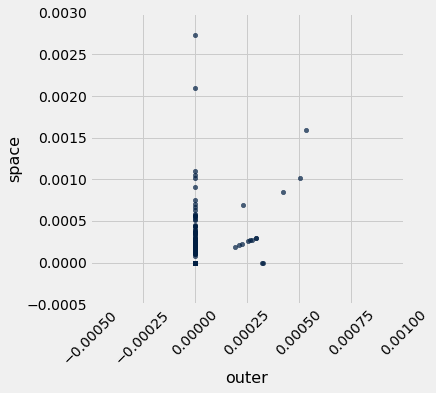

In [ ]:
outer_space = movies.select("outer", "space")
outer_space.scatter("outer", "space")
plots.axis([-0.0005, 0.001, -0.0005, 0.003]);
plots.xticks(rotation=45);

Looking at that chart it is difficult to see if there is an association. Let's calculate the correlation coefficient for the potential linear association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset, and assign it to `outer_space_r`.

In [ ]:
outer = movies.column("outer")
space = movies.column("space")

outer_su = (outer - np.average(outer))/np.std(outer)
space_su = (space - np.average(space))/np.std(space)

outer_space_r = np.average((outer_su) * space_su)
outer_space_r

0.3194260787689591

#### Question 1.2.1
Find two words with a correlation magnitude greater than 0.2.


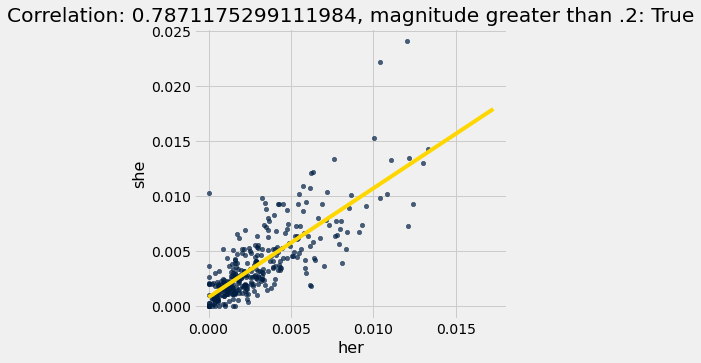

In [ ]:
word_x = 'her'
word_y = 'she'

arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = (arr_x - np.average(arr_x))/np.std(arr_x)
y_su = (arr_y - np.average(arr_y))/np.std(arr_y)

r = np.mean(x_su * y_su)

slope = r * (np.std(arr_y)/np.std(arr_x))
intercept = np.mean(arr_y) - slope * np.mean(arr_x)

movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plots.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plots.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color='gold');

Imagine that you picked the words "san" and "francisco" as the two words that you would expect to be correlated because they compose the city name San Francisco.

- "san" can also preceed other city names like San Diego and San Jose. This might lead to "san" appearing in movies without "francisco," and would reduce the correlation between "san" and "francisco."

## 1.3. Splitting the dataset
Now, we're going to use our `movies` dataset for two purposes.

1. First, we want to *train* movie genre classifiers.
2. Second, we want to *test* the performance of our classifiers.

The purpose of a classifier is to classify unseen data that is similar to the training data. The test dataset will help us determine the accuracy of our predictions by comparing the actual genres of the movies with the genres that our classifier predicts. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the first 85% of the dataset for training and the rest for test.

In [ ]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)

Training:  283 ; Test:  50


<!-- BEGIN QUESTION -->

#### Question 1.3.1
What proportion of Comedy movies is in each dataset?

We can a horizontal bar chart with two bars that show the proportion of Comedy movies in each dataset (`train_movies` and `test_movies`).

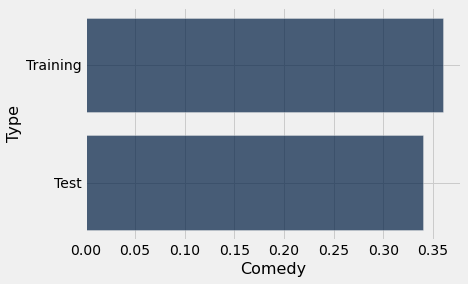

In [ ]:
def comedy_proportion(table):
    # Return the proportion of movies in a table that have the comedy genre.
    num_com = table.where('Genre', 'comedy').num_rows
    return num_com/ table.num_rows

com_val = make_array(comedy_proportion(train_movies), comedy_proportion(test_movies))
com_movies = Table().with_columns('Type', make_array('Training', 'Test'),'Comedy', com_val)
com_movies.barh('Type')

<!-- END QUESTION -->



# Part 2: K-Nearest Neighbors

[K-Nearest Neighbors (k-NN)](https://inferentialthinking.com/chapters/17/1/Nearest_Neighbors.html) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides which category that example belongs to based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movie*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

## 2.1. Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "water" and "feel" in the movie.  Taking the movie *Monty Python and the Holy Grail* (in the test set), 0.000804074 of its words are "water" and 0.0010721 are "feel". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two movies is the straight-line distance between them when we plot their features on a scatter diagram.

**This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$.**

For example, in the movie *Clerks.* (in the training set), 0.00016293 of all the words in the movie are "water" and 0.00154786 are "feel".  Its distance from *Monty Python and the Holy Grail* on this 2-word feature set is $\sqrt{(0.000804074 - 0.000162933)^2 + (0.0010721 - 0.00154786)^2} \approx 0.000798379$.  (If we included more or different features, the distance could be different.)

A third movie, *The Godfather* (in the training set), has 0 "water" and 0.00015122 "feel".

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies. As you can see in the result, *Monty Python and the Holy Grail* is more similar to *Clerks.* than to the *The Godfather* based on these features, which makes sense as both movies are comedy movies, while *The Godfather* is a thriller.

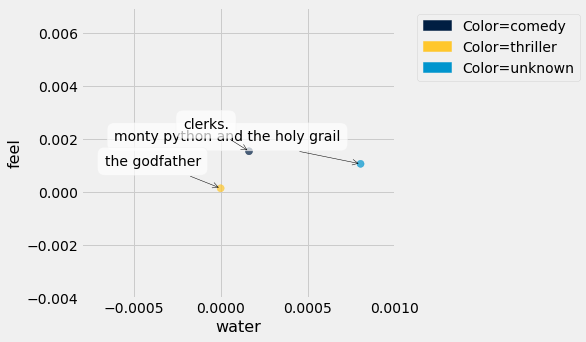

In [ ]:
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=50)

training = ["clerks.", "the godfather"]
plot_with_two_features("monty python and the holy grail", training, "water", "feel")
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

#### Question 2.1.1

Compute the Euclidean distance between "Monty Python and the Holy Grail" and "The Godfather" using "water" and "feel" features.

In [ ]:
python = row_for_title("monty python and the holy grail")
godfather = row_for_title("the godfather")

one_distance = np.sqrt(((python.item('water')-godfather.item('water'))**2 + (python.item('feel')-godfather.item('feel'))**2))
one_distance

0.0012225209151294461

Below, we've added a third training movie, *The Silence of the Lambs*. Before, the point closest to *Monty Python and the Holy Grail* was *Clerks.*, a comedy movie. However, now the closest point is *The Silence of the Lambs*, a thriller movie.

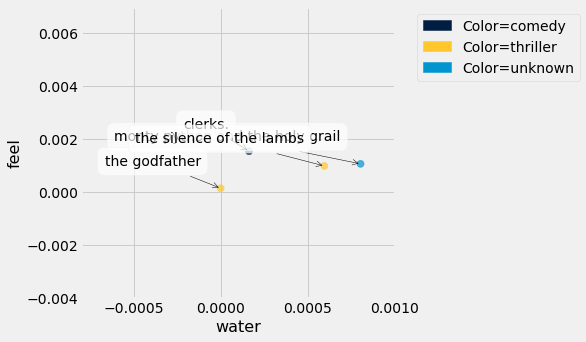

In [ ]:
training = ["clerks.", "the godfather", "the silence of the lambs"]
plot_with_two_features("monty python and the holy grail", training, "water", "feel")
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

#### Question 2.1.2
Below is a function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call the function to show that *Monty Python and the Holy Grail* is closer to *The Silence of the Lambs* than it is to *Clerks*.

In [ ]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1.

    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = (row_for_title(title0).item(x_feature) - row_for_title(title1).item(x_feature))**2
    row1 = (row_for_title(title1).item(y_feature) - row_for_title(title0).item(y_feature))**2
    return np.sqrt(row0 + row1)

for movie in make_array("clerks.", "the silence of the lambs"):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance:\t', movie_distance)

clerks. distance:	 0.0007983810687227716
the silence of the lambs distance:	 0.00022256314855564847


#### Question 2.1.3
I define a function `distance_from_python` so that it works as described in its documentation.

In [ ]:
def distance_from_python(title):
    """The distance between the given movie and "monty python and the holy grail",
    based on the features "water" and "feel".

    This function takes a single argument:
      title: A string, the name of a movie.
    """
    return distance_two_features('monty python and the holy grail', title, "water", "feel")


# Calculate the distance between "Clerks." and "Monty Python and the Holy Grail"
distance_from_python('clerks.')

0.0007983810687227716

#### Question 2.1.4

Using the features `"water"` and `"feel"`, what are the names and genres of the 5 movies in the **training set** closest to *Monty Python and the Holy Grail*?  

*Note:* Why are smaller distances from *Monty Python and the Holy Grail* more helpful in helping us classify the movie?

In [ ]:
dis_movies = train_movies.apply(distance_from_python, 'Title')
new_movies_tbl = train_movies.with_columns('distance from python', dis_movies).sort('distance from python')
close_movies = new_movies_tbl.select('Title', 'Genre', 'water', 'feel', 'distance from python').take(np.arange(0,5))
close_movies

Title,Genre,water,feel,distance from python
alien,thriller,0.00070922,0.00124113,0.000193831
tomorrow never dies,thriller,0.000888889,0.000888889,0.00020189
the silence of the lambs,thriller,0.000595948,0.000993246,0.000222563
innerspace,comedy,0.000522193,0.00104439,0.00028324
some like it hot,comedy,0.000528541,0.000951374,0.00030082


#### Question 2.1.5
Next, we'll clasify *Monty Python and the Holy Grail* based on the genres of the closest movies.

To do so, I define the function `most_common` so that it returns the most common value in the label column of the table.

In [ ]:
def most_common(label, table):
    """The most common element in a column of a table.

    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.

    It returns the most common value in the label column of the table.
    In case of a tie, it returns any one of the most common values.
    """
    return table.group(label).sort('count', descending=True).column(label).item(0)

# Calling most_common on your table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2.
most_common('Genre', close_movies)

'thriller'

# Part 3: Features

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

#### Question 3.0
The function `distance` computes the Euclidean distance between two **arrays** of **numerical** features. This function should handle arrays of arbitrary (but equal) length. Compute the distance **between the first and second movie** in the **training set** using all of the features.


In [ ]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    return (sum((features_array1 - features_array2)**2)) **(1/2)

newT = train_movies.drop(0, 1, 2, 3, 4)
distance_first_to_second = distance(np.array(newT.row(0)), np.array(newT.row(1)))
distance_first_to_second

0.033354468908813176

## 3.1. Creating your own feature set

Unfortunately, using all of the features has some downsides.  One clear downside is the lack of *computational efficiency* -- computing Euclidean distances just takes a long time when we have lots of features.

So we're going to select just 20.  We'd like to choose features that are very *discriminative*. That is, features which lead us to correctly classify as much of the test set as possible.

In this question, we will help you get started on selecting more effective features for distinguishing comedy from thriller movies. The plot below shows the average number of times each word occurs in a comedy movie on the horizontal axis and the average number of times it occurs in an thriller movie on the vertical axis.


*Note: The line graphed is the line of best fit, NOT the line y=x.*

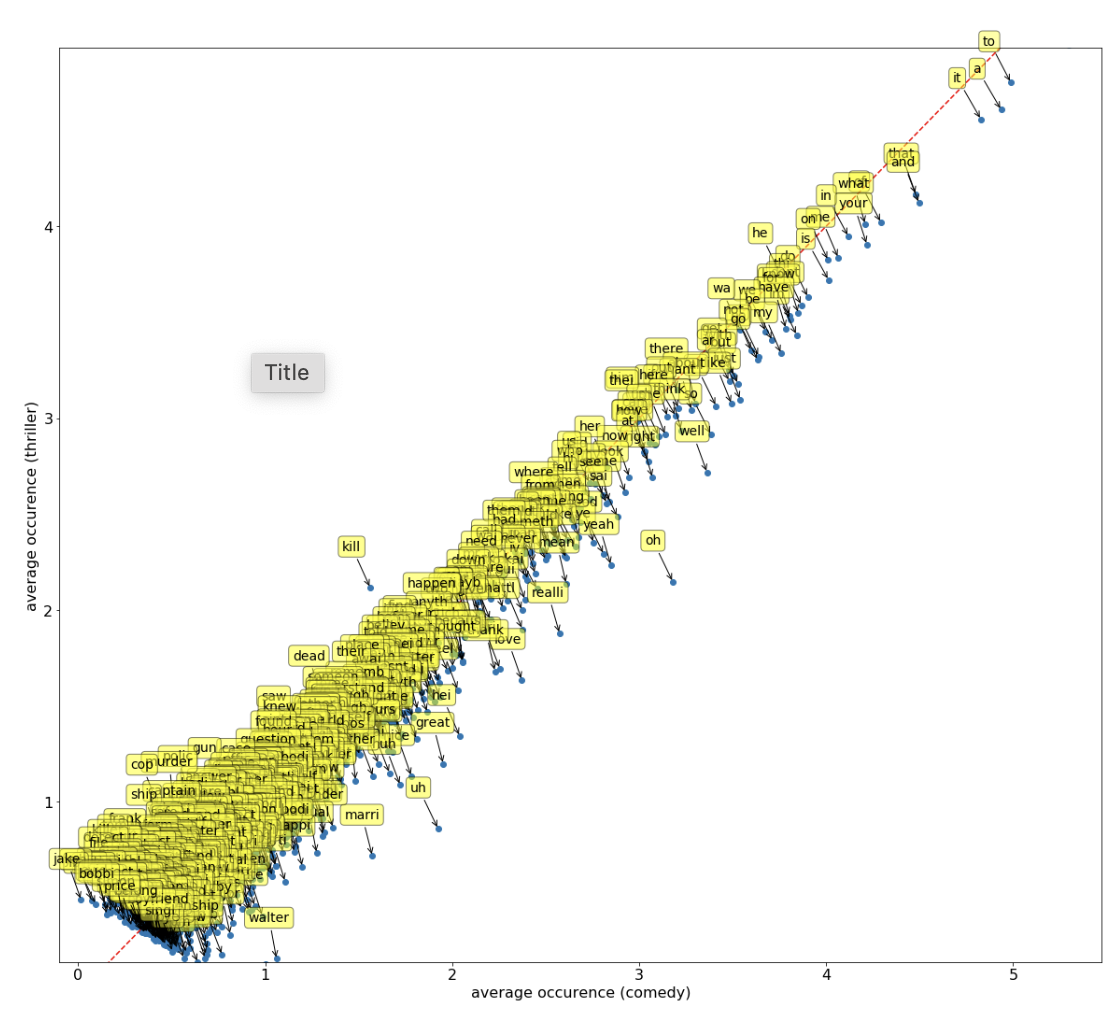

**Question 3.1.1**

What properties do words in the bottom left corner of the plot have?

Words in the bottom left corner of the plot are uncommon in both comedy and thriller movies. These words have low frequencies in both genres, indicating they are not prominent in either type of movie.

**Question 3.1.2**

What properties do words in the bottom right corner have?

Words in the bottom right corner are common in comedy movies but uncommon in thriller movies. These words are more likely to be associated with comedic contexts and provide good discriminative power for identifying comedies.

**Question 3.1.3**

What properties do words in the top right corner have?

Words in the top right corner are common in both comedy and thriller movies. These words are prevalent across both genres and thus do not help much in distinguishing between the two.

**Question 3.1.4**

What properties do words in the top left corner have?

Words in the top left corner are uncommon in comedy movies but common in thriller movies. These words are more likely to be associated with thriller contexts and can be used to identify thrillers effectively.

**Question 3.1.5**

If we see a movie with a lot of words that are common for comedy movies but uncommon for thriller movies, what would be a reasonable guess about the genre of the movie?

If a movie has many words that are common in comedies but uncommon in thrillers, it is reasonable to predict the movie as a comedy. This distinction is based on the high association of these words with comedic contexts and their rarity in thrillers.

#### Question 3.1.6
Using the plot above, I want to make an array of at least 10 common words that I think might let me **distinguish** between comedy and thriller movies.


In [ ]:
# Set my_features to an array of at least 10 features (strings that are column labels)

my_features = make_array('guitar', 'time', 'her', 'new', 'love', 'to', 'fun', 'scene', 'no', 'great')

# Select the 10 features of interest from both the train and test sets
train_my_features = train_movies.select(my_features)
test_my_features = test_movies.select(my_features)

I referred back to the plot and sort of randomly selected words that I think would appear in all possible movies.

Next, let's classify the first movie from our test set using these features.

In [ ]:
print("Movie:")
test_movies.take(0).select('Title', 'Genre').show()
print("Features:")
test_my_features.take(0).show()

Movie:


Title,Genre
ghostbusters ii,comedy


Features:


guitar,time,her,new,love,to,fun,scene,no,great
0,0.00181339,0.00214309,0.00214309,0.000824266,0.0285196,0.00049456,0,0.00461589,0.000659413


As before, we want to look for the movies in the training set that are most like our test movie.  We will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set.

In [ ]:
def fast_distances(test_row, train_table):
    """Return an array of the distances between test_row and each row in train_table.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_my_features.row(0)).
      train_table: A table of features (for example, the whole
        table train_my_features)."""
    assert train_table.num_columns < 50, "Make sure you're not using all the features of the movies table."
    assert type(test_row) != datascience.tables.Table, "Make sure you are passing in a row object to fast_distances."
    assert len(test_row) == len(train_table.row(0)), "Make sure the length of test row is the same as the length of a row in train_table."
    counts_matrix = np.asmatrix(train_table.columns).transpose()
    diff = np.tile(np.array(list(test_row)), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

#### Question 3.1.7
Now we're use the `fast_distances` function  above to compute the distance from the first movie in your test set to all the movies in your training set, **using your set of features**.

In [ ]:
genre = train_movies.column('Genre')
distance = fast_distances(test_my_features.row(0), train_my_features)

genre_and_distances = Table().with_columns('Genre', genre, 'Distance', distance).sort('Distance')
genre_and_distances

Genre,Distance
comedy,0.00185948
comedy,0.00202457
thriller,0.00202457
thriller,0.00225901
thriller,0.00235926
comedy,0.00242149
comedy,0.0024384
thriller,0.0024911
thriller,0.00259987
thriller,0.00260333


#### Question 3.1.8
Now we'll compute the 7-nearest neighbors classification of the first movie in the test set.  That is, decide on its genre by finding the most common genre among its 7 nearest neighbors in the training set, according to the distances I've calculated.

In [ ]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = most_common('Genre', genre_and_distances.take(make_array(1,8)))

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set, False otherwise.
my_assigned_genre_was_correct = True

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, comedy, was correct.


## 3.2. A classifier function

Now we can write a single function that encapsulates the whole process of classification.

#### Question 3.2.1
I will call this function `classify`.  It should take the following four arguments:
* A row of features for a movie to classify (e.g., `test_my_features.row(0)`).
* A table with a column for each feature (e.g., `train_my_features`).
* An array of classes (e.g. the labels "comedy" or "thriller") that has as many items as the previous table has rows, and in the same order. *Hint:* What are the labels of each row in the training set?
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'comedy'` or the string `'thriller'`).


In [ ]:
def classify(test_row, train_features, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_features)
    genre_and_distances = Table().with_columns('Genre', train_labels, 'Distance', distances).sort('Distance')
    return most_common('Genre', genre_and_distances.take(np.arange(k)))

#### Question 3.2.2

To test our function let's assign `godzilla_genre` to the genre predicted by the classifier for the movie "godzilla" in the test set, using **15 neighbors** and using your 10 features.

In [ ]:
godzilla_features = test_movies.where('Title', 'godzilla').select(my_features).row(0)
godzilla_genre = classify(godzilla_features, test_my_features, test_movies.column('Genre'), 15)
godzilla_genre

'thriller'

Finally, when we evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

#### Question 3.2.3
Next we'll create a classification function that takes as its argument a row containing your 10 features and classifies that row using the 15-nearest neighbors algorithm with `train_my_features` as its training set.

In [ ]:
def classify_feature_row(row):
    return classify(row, train_my_features, train_movies.column('Genre'), 15)

# this should produce 'thriller' or 'comedy'.
classify_feature_row(test_my_features.row(0))

'thriller'

## 3.3. Evaluating our classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

**Question 3.3.1**

Use `classify_feature_row` and `apply` to classify every movie in the test set.

In [ ]:
test_guesses = test_movies.select('Genre').with_columns('Guess', test_movies.select(my_features).apply(classify_feature_row))
proportion_correct = np.count_nonzero(test_guesses.column('Genre') == test_guesses.column('Guess')) / test_guesses.num_rows
proportion_correct

0.64

**Question 3.3.2**

An important part of evaluating your classifiers is figuring out where they make mistakes. We'll assign the name `test_movie_correctness` to a table with three columns, `'Title'`, `'Genre'`, and `'Was correct'`.

- The `'Genre'` column should contain the original genres, not the ones you predicted.
- The `'Was correct'` column should contain `True` or `False` depending on whether or not the movie was classified correctly.

In [ ]:
newTbl = test_movies.select('Title', 'Genre')
test_movie_correctness = newTbl.with_columns('Was correct', test_guesses.column('Genre') == test_guesses.column('Guess'))
test_movie_correctness.sort('Was correct', descending = True).show(50)

Title,Genre,Was correct
intolerable cruelty,comedy,True
psycho,thriller,True
book of shadows: blair witch 2,thriller,True
the getaway,thriller,True
mission: impossible,thriller,True
arctic blue,thriller,True
the world is not enough,thriller,True
leviathan,thriller,True
the atomic submarine,thriller,True
halloween 4: the return of michael myers,thriller,True


<!-- BEGIN QUESTION -->

**Question 3.3.3**

Any pattern in the types of movies the classifier misclassifies?

The table above shows that the classifier is more than 50% correct while less than 50% of the guesses were incorrect. There seems to be a pattern where the classifier guesses more 'thriller' genre than 'comdedy'. Almost all of the thriller movies were guessed correctly while most comedy guesses turn out to be incorrect. And based on the title of the movies, like spider-man which wouldn't really fit in the thriller catagory but somehow is considered thriller even in the prediction or on the hand, 'ghostbuster' would be.